In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml
import os
from collections import Counter
from typing import List, Dict, Any, Tuple

In [2]:
os.chdir(
    ".."
)  # Change working directory to root of repository for paths to be consistent

In [34]:
with open("config/params.yaml") as f:
    params = yaml.safe_load(f)

# Load the data files
train_file = params["files"]["train"]
test_file = params["files"]["test"]
output_file = params["files"]["output"]

# Load the model parameters
nn_params = params["nn"]
nn_train_params = params["nn_train"]
callbacks = None

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Check the data
print(train_data.head())

  Sequence  Active
0     DKWL       0
1     FCHN       0
2     KDQP       0
3     FNWI       0
4     NKRM       0


### Visualizing Data Distribution

Visualizing features and labels is essential to understand patterns in the dataset:  

- **Feature Distribution**: Use histograms to visualize the frequency of each amino acid in the dataset.
    This helps identify imbalances in amino acid representation, which could influence model performance.
- **Label Distribution**: Bar plots help identify class imbalances or anomalies in categorical labels.  
- **Feature Relationships**: Correlation heatmaps reveal dependencies between features.


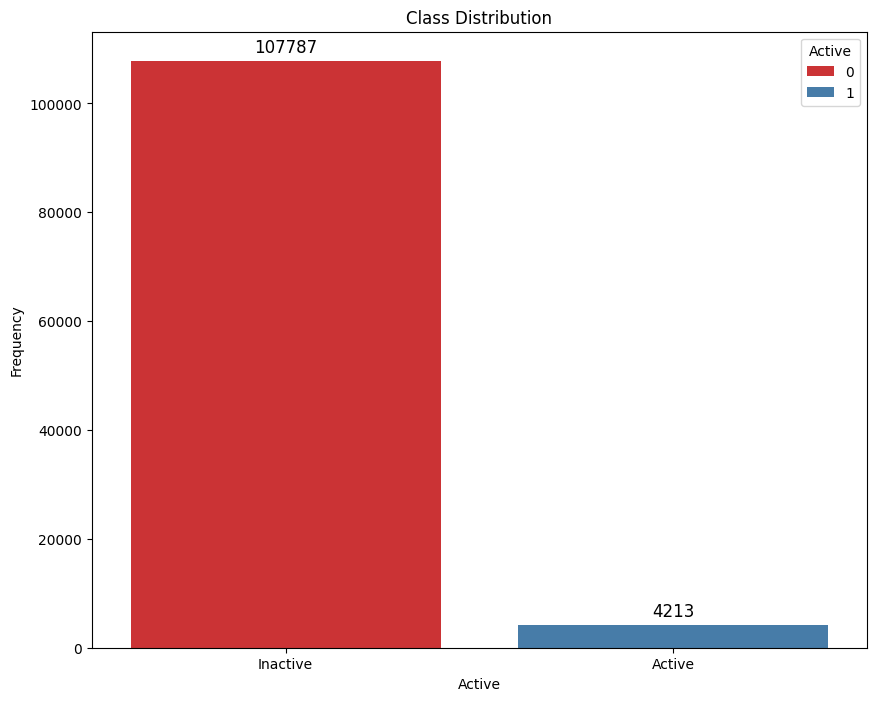

In [4]:
labels = train_data["Active"]

class_counts = labels.value_counts()

# Plot the class distribution
plt.figure(figsize=(10, 8))
ax = sns.countplot(x=labels, palette="Set1", hue=labels)
plt.title("Class Distribution")
plt.xlabel("Active")
plt.ylabel("Frequency")
plt.xticks(ticks=[0, 1], labels=["Inactive", "Active"])

# Add the count labels on top of the bars
for p in ax.patches:
    count = int(p.get_height())  # Get the count of the bar
    if p.get_width() > 0:
        ax.annotate(
            f"{count}",  # Display the count
            (p.get_x() + p.get_width() / 2.0, p.get_height()),  # Position of the label
            ha="center",
            va="center",  # Horizontal and vertical alignment
            fontsize=12,
            color="black",  # Font size and color
            xytext=(0, 10),  # Offset the label slightly above the bar
            textcoords="offset points",
        )

plt.show()

In [5]:
# Constants
AMINOACIDS = [
    "A",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "K",
    "L",
    "M",
    "N",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "V",
    "W",
    "Y",
    ]
CHARGED_AA = ["R", "H", "K", "D", "E"]

### Amino Acid Sequence Visualization

This function visualizes the amino acid sequence features in three distinct ways to analyze different properties of the dataset:

1. **Frequency Distribution**:  
   A bar plot that displays the overall frequency of each amino acid across the dataset. This helps identify underrepresented or overrepresented amino acids that might affect the analysis or model performance.

2. **Dimer Frequency Heatmap**:  
   A heatmap showing the frequency of all possible amino acid pairs (dimers) in the dataset. This helps capture sequence patterns or dependencies between adjacent amino acids.

3. **Position-Specific Frequency Heatmap**:  
   A heatmap that visualizes the frequency of each amino acid at each specific position in the sequence. This is especially useful for understanding positional biases or conserved patterns within the sequences.

These visualizations provide insights into amino acid composition, sequence structure, and positional preferences, enabling better feature engineering and model understanding.


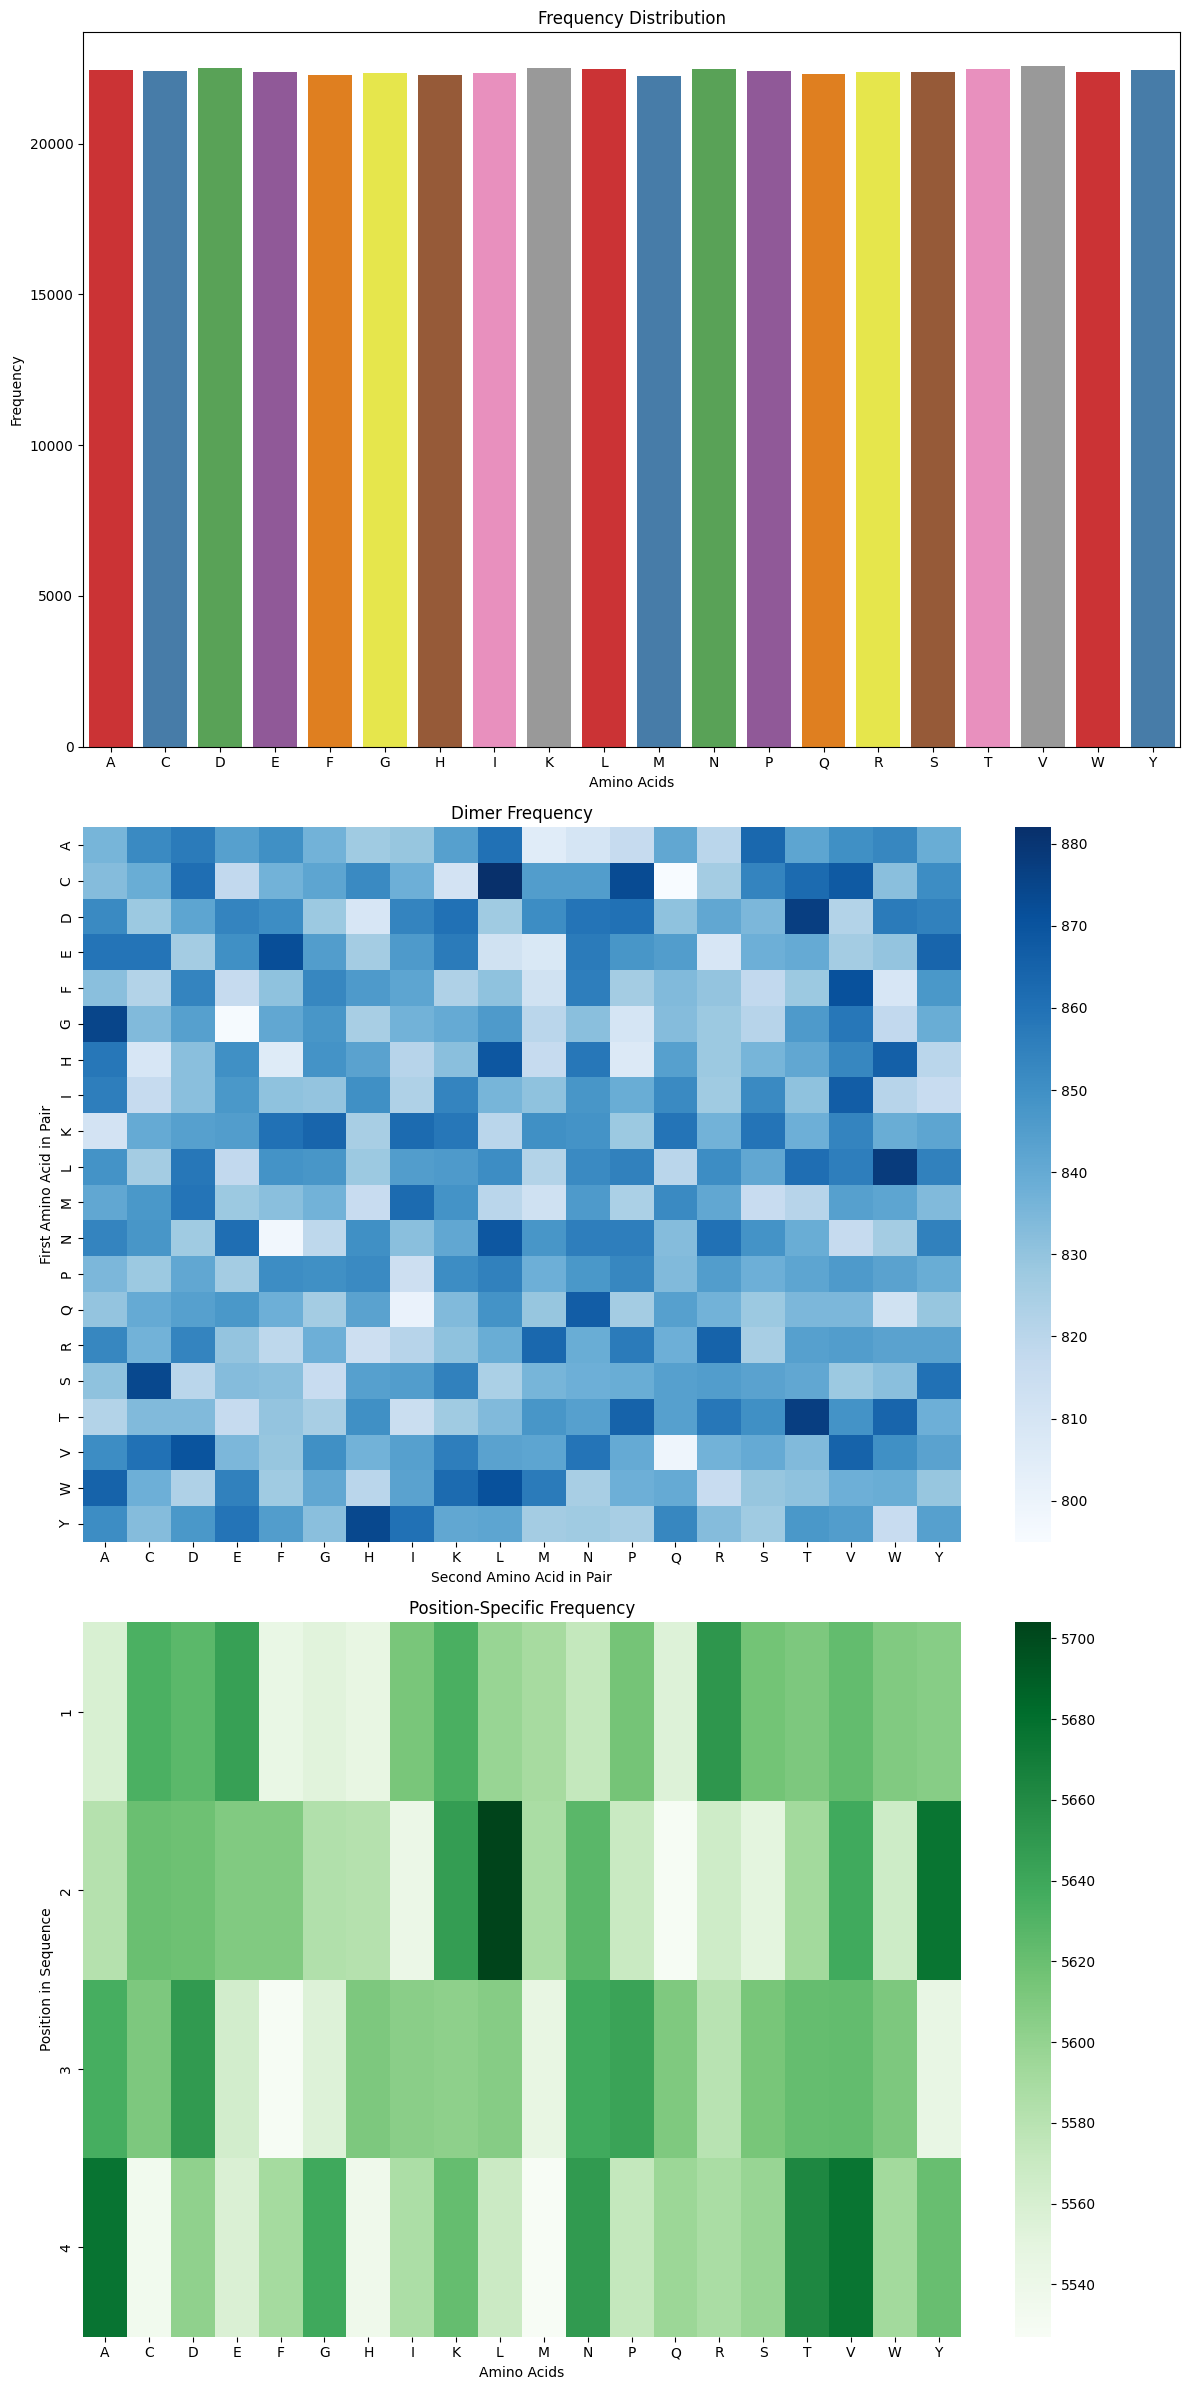

In [6]:
features = train_data["Sequence"]

# 1. Frequency Distribution
# Flatten the list of sequences to a single list of amino acids
all_aa = "".join(features.values)
aa_counts = Counter(all_aa)
aa_counts = dict(sorted(aa_counts.items()))

# 2. Dimer Frequency
# Generate all adjacent pairs (dimers)
pairs = [seq[i : i + 2] for seq in features for i in range(len(seq) - 1)]
pair_counts = Counter(pairs)

# Create a 2D matrix for the dimer heatmap
pair_matrix = np.zeros((len(AMINOACIDS), len(AMINOACIDS)))

for pair, count in pair_counts.items():
    i, j = AMINOACIDS.index(pair[0]), AMINOACIDS.index(pair[1])
    pair_matrix[i, j] = count

# 3. Position-Specific Frequency
# Transpose the sequences so each row is a position and each column is an amino acid
sequences_transposed = list(zip(*features))
positions = len(sequences_transposed)

# Count the occurrence of each amino acid at each position
aa_positions = []
for i in range(positions):
    aa_count = Counter(sequences_transposed[i])
    aa_positions.append(aa_count)

# Convert position-specific counts to a matrix
position_matrix = np.zeros((positions, len(AMINOACIDS)))

for i, count in enumerate(aa_positions):
    for aa, c in count.items():
        position_matrix[i, AMINOACIDS.index(aa)] = c

# Plot all subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 24))

# Frequency Distribution Plot
sns.barplot(
    x=list(aa_counts.keys()),
    y=list(aa_counts.values()),
    ax=axes[0],
    palette="Set1",
    hue=list(aa_counts.keys()),
)
axes[0].set_title("Frequency Distribution")
axes[0].set_xlabel("Amino Acids")
axes[0].set_ylabel("Frequency")

# Dimer Frequency Heatmap
sns.heatmap(
    pair_matrix,
    xticklabels=AMINOACIDS,
    yticklabels=AMINOACIDS,
    cmap="Blues",
    # annot=True,
    ax=axes[1],
)
axes[1].set_title("Dimer Frequency")
axes[1].set_xlabel("Second Amino Acid in Pair")
axes[1].set_ylabel("First Amino Acid in Pair")

# Position-Specific Frequency Heatmap
sns.heatmap(
    position_matrix,
    xticklabels=AMINOACIDS,
    yticklabels=range(1, positions + 1),
    cmap="Greens",
    # annot=True,
    ax=axes[2],
)
axes[2].set_title("Position-Specific Frequency")
axes[2].set_xlabel("Amino Acids")
axes[2].set_ylabel("Position in Sequence")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

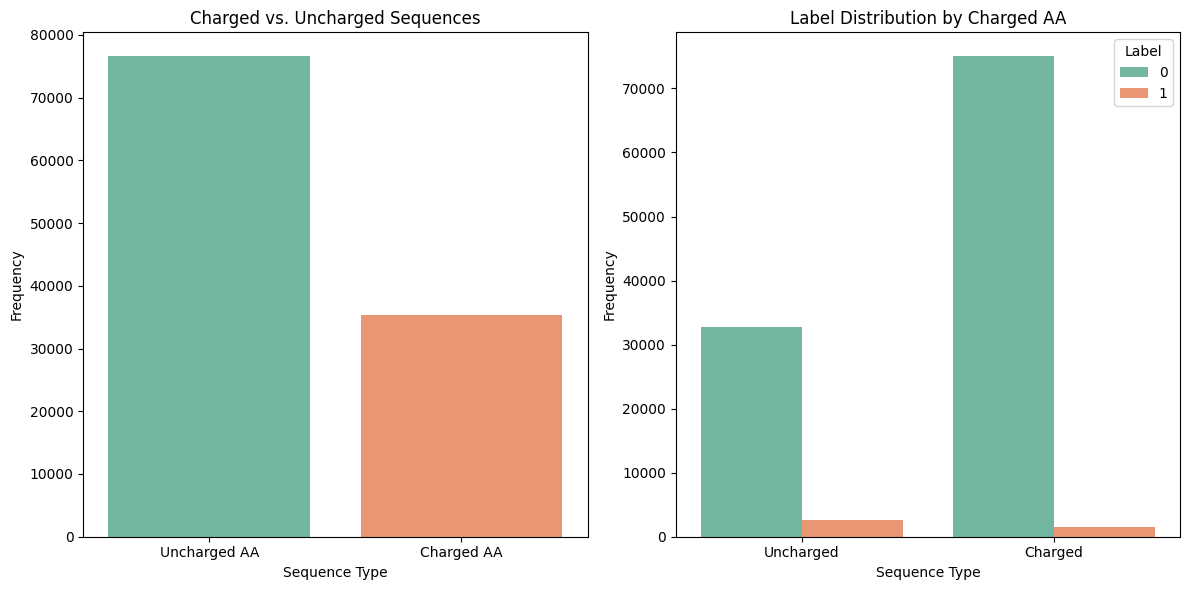

In [7]:
charged_seq = features.apply(lambda seq: any(aa in seq for aa in CHARGED_AA))
charged_counts = charged_seq.value_counts()
charged_counts.index = ["Uncharged AA", "Charged AA"]

# Plot proportion of charged vs. uncharged sequences
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=charged_counts.index, y=charged_counts.values, palette="Set2", hue=charged_counts.index)
plt.title("Charged vs. Uncharged Sequences")
plt.ylabel("Frequency")
plt.xlabel("Sequence Type")

# Label distribution for charged and uncharged sequences
charged_activity = pd.DataFrame({"Charged Sequences": charged_seq, "Active": labels})
grouped_counts = charged_activity.groupby(["Charged Sequences", "Active"]).size().reset_index(name="Frequency")

# Plot stacked bar chart for label distribution
plt.subplot(1, 2, 2)
sns.barplot(
    data=grouped_counts,
    x="Charged Sequences",
    y="Frequency",
    hue="Active",
    palette="Set2",
)
plt.title("Label Distribution by Charged AA")
plt.xlabel("Sequence Type")
plt.ylabel("Frequency")
plt.xticks(ticks=[0, 1], labels=["Uncharged", "Charged"])
plt.legend(title="Label")

plt.tight_layout()
plt.show()


### Testing Approaches to Handle Class Imbalance

To address class imbalance in the dataset, we will compare two common strategies for balancing the data during training:  

1. **Oversampling with RandomOverSampler**:  
   This approach artificially increases the number of samples for the minority class by duplicating instances. The degree of oversampling is controlled by a hyperparameter that seeks to balance the trade-off between mitigating class imbalance and avoiding overfitting.
2. **Class Weights in Neural Network Training**:  
   This technique assigns higher weights to the minority class during training, making the model penalize misclassifications of the minority class more than the majority class. It directly modifies the training loss function to account for imbalance without altering the data.

We will evaluate both methods using the same neural network architecture and training parameters. The effectiveness of each approach will be assessed based on the following criteria:  
- **Precision, Recall, and F1-score**: These metrics reflect how well the approach handles imbalance.  
- **Overall model accuracy**: Ensures that the model maintains good performance across all classes.  

By comparing these methods, we aim to identify the most suitable approach for tackling class imbalance in our specific dataset.

In [8]:
from main import build_model, train_model, cross_validate_model, encode_protein, METRICS
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
SEED = 42
CV_SPLITS = 3
METRIC_NAMES = ["loss", "accuracy", "precision", "recall", "auc", "f1"]

# Encode the protein sequences into one-hot vectors
X_train, y_train, X_test = encode_protein(
    train_file, test_file, aminoacids=AMINOACIDS, charged_aa=CHARGED_AA
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=TEST_SIZE, random_state=SEED
)

In [9]:
# Oversample the minority class
from imblearn.over_sampling import SMOTE, RandomOverSampler

SAMPLING_FACTORS = [0.25, 0.5, 0.75, 1.0]

def train_with_oversampling(
        model_params: Dict,
        train_params: Dict,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val: np.ndarray,
        y_val: np.ndarray,
        callbacks: List[Any],
        sampling_factor: float
    ) -> Dict:

    oversampler = RandomOverSampler(
        sampling_strategy=sampling_factor, random_state=SEED
    )
    X_resampled, y_resampled = oversampler.fit_resample(
        X_train, y_train
    )

    train_params["weighted"] = False  # Disable class weights when using oversampling
    print(f"Training with oversampling factor: {sampling_factor}")

    model, history = train_model(
        X_resampled,
        y_resampled,
        model_params,
        **train_params,
        callbacks=callbacks,
    )

    val_score = model.evaluate(X_val, y_val, verbose=0)
    val_score_dict = dict(zip(METRIC_NAMES, val_score))

    res = {"model": model, "scores": val_score_dict}

    return res

oversampling_results = [
    train_with_oversampling(
        model_params=nn_params,
        train_params=nn_train_params,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        callbacks=callbacks,
        sampling_factor=factor,
    )
    for factor in SAMPLING_FACTORS
]
oversampling_results

Training with oversampling factor: 0.25
Epoch 1/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8857 - auc: 0.9183 - f1: 0.5241 - loss: 0.3016 - precision: 0.7834 - recall: 0.5142
Epoch 2/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9655 - auc: 0.9891 - f1: 0.9122 - loss: 0.1469 - precision: 0.9082 - recall: 0.9194
Epoch 3/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9717 - auc: 0.9918 - f1: 0.9274 - loss: 0.1298 - precision: 0.9211 - recall: 0.9375
Epoch 4/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9751 - auc: 0.9941 - f1: 0.9371 - loss: 0.1166 - precision: 0.9265 - recall: 0.9498
Epoch 5/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9778 - auc: 0.9948 - f1: 0.9446 - loss: 0.1086 - precision: 0.9302 - recall: 0.9609
Epoch 6/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9798 - auc: 0.9958 - f1: 0.9491 - loss: 0.1006 - precision: 0.9356 - recall: 0.9657
Epoch 7/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accur

[{'model': <Sequential name=sequential, built=True>,
  'scores': {'loss': 0.0671662762761116,
   'accuracy': 0.9864285588264465,
   'precision': 0.753564178943634,
   'recall': 0.9226932525634766,
   'auc': 0.9933696985244751,
   'f1': 0.6020060777664185}},
 {'model': <Sequential name=sequential_1, built=True>,
  'scores': {'loss': 0.06376393139362335,
   'accuracy': 0.9898660778999329,
   'precision': 0.8155872821807861,
   'recall': 0.9264339208602905,
   'auc': 0.9952899217605591,
   'f1': 0.6264989972114563}},
 {'model': <Sequential name=sequential_2, built=True>,
  'scores': {'loss': 0.08291038870811462,
   'accuracy': 0.9819642901420593,
   'precision': 0.6733449697494507,
   'recall': 0.9638404250144958,
   'auc': 0.9954578876495361,
   'f1': 0.5978212952613831}},
 {'model': <Sequential name=sequential_3, built=True>,
  'scores': {'loss': 0.08503998070955276,
   'accuracy': 0.981071412563324,
   'precision': 0.6582914590835571,
   'recall': 0.9800498485565186,
   'auc': 0.996950

In [16]:
best_oversampling_result = max(oversampling_results, key=lambda x: x["scores"]["f1"])
best_oversampling_model = best_oversampling_result["model"]
best_oversampling_score = best_oversampling_result["scores"]
best_oversampling_score

{'loss': 0.06376393139362335,
 'accuracy': 0.9898660778999329,
 'precision': 0.8155872821807861,
 'recall': 0.9264339208602905,
 'auc': 0.9952899217605591,
 'f1': 0.6264989972114563}

In [19]:
def training_with_class_weights(
    model_params: Dict,
    train_params: Dict,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    callbacks: List[Any] = None,
) -> Dict:

    train_params["weighted"] = True
    print(f'weighted: {train_params["weighted"]}')

    model, history = train_model(
        X_train,
        y_train,
        model_params,
        **train_params,
        callbacks=callbacks,
    )

    val_score = model.evaluate(X_val, y_val, verbose=0)
    val_score_dict = dict(zip(METRIC_NAMES, val_score))

    res = {"model": model, "scores": val_score_dict}

    return res


class_weight_results = training_with_class_weights(
    model_params=nn_params,
    train_params=nn_train_params,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    callbacks=callbacks,
)
class_weight_model = class_weight_results["model"]
class_weight_scores = class_weight_results["scores"]
class_weight_results

weighted: True
Epoch 1/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9386 - auc: 0.9698 - f1: 0.3940 - loss: 0.4170 - precision: 0.3658 - recall: 0.8578
Epoch 2/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9345 - auc: 0.9812 - f1: 0.5115 - loss: 0.2134 - precision: 0.3628 - recall: 0.9561
Epoch 3/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9451 - auc: 0.9856 - f1: 0.5620 - loss: 0.1908 - precision: 0.4099 - recall: 0.9656
Epoch 4/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9507 - auc: 0.9884 - f1: 0.5775 - loss: 0.1745 - precision: 0.4302 - recall: 0.9675
Epoch 5/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9562 - auc: 0.9904 - f1: 0.6072 - loss: 0.1593 - precision: 0.4613 - recall: 0.9762
Epoch 6/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9557 - auc: 0.9905 - f1: 0.6074 - loss: 0.1624 - precision: 0.4629 - recall: 0.9718
Epoch 7/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9581 - a

{'model': <Sequential name=sequential_5, built=True>,
 'scores': {'loss': 0.15077711641788483,
  'accuracy': 0.9610714316368103,
  'precision': 0.4788135588169098,
  'recall': 0.9862843155860901,
  'auc': 0.9958080053329468,
  'f1': 0.5211633443832397}}

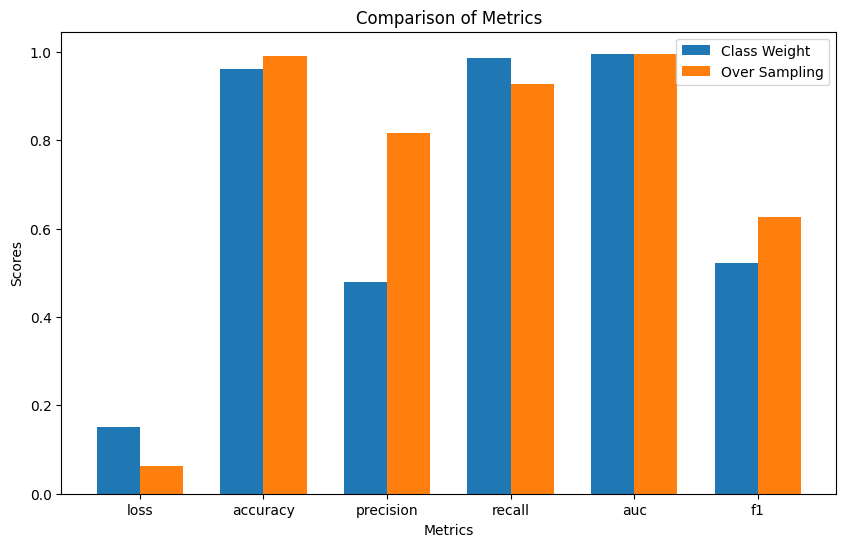

In [20]:
class_weight_values = list(class_weight_scores.values())
oversampling_values = list(best_oversampling_score.values())

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars on the x-axis
class_positions = range(len(METRIC_NAMES))
oversampling_positions = [pos + bar_width for pos in class_positions]

# Create the bar plots
class_weight_bars = ax.bar(class_positions, class_weight_values, bar_width, label='Class Weight')
val_bars = ax.bar(oversampling_positions, oversampling_values, bar_width, label='Over Sampling')

# Add labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics')

# Set the x-axis tick labels
ax.set_xticks([pos + bar_width/2 for pos in class_positions])
ax.set_xticklabels(METRIC_NAMES)

# Add legend
ax.legend()

# Show the plot
plt.show()

700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


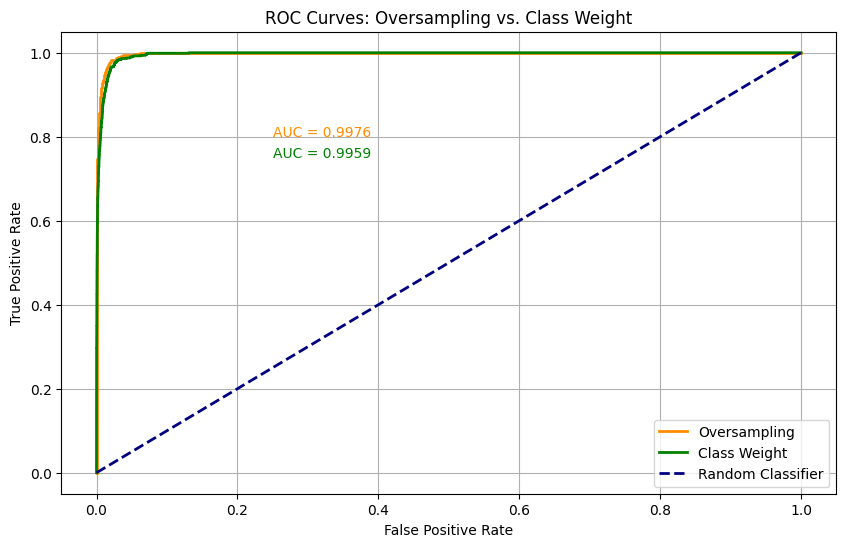

In [29]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 6))

# Plot the ROC curve for the oversampling model
y_pred_oversampling = best_oversampling_model.predict(X_val)

fpr, tpr, thresholds = roc_curve(y_val, y_pred_oversampling)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='Oversampling')
plt.text(0.25, 0.8, f"AUC = {roc_auc:.4f}", color="darkorange")

# Plot the ROC curve for the class weight model
y_pred_class_weight = class_weight_model.predict(X_val)

fpr, tpr, thresholds = roc_curve(y_val, y_pred_class_weight)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='green', lw=2, label='Class Weight')
plt.text(0.25, 0.75, f"AUC = {roc_auc:.4f}", color="green")

# Plot the random classifier line
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Classifier")


# Add plot details
plt.title("ROC Curves: Oversampling vs. Class Weight")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [40]:
# Assign the best model and scores to the final variables to use in the next step (Model Selection)
best_nn_model = best_oversampling_model
best_nn_scores = best_oversampling_score

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

rf_params = params["rf"]

rf = RandomForestClassifier(**rf_params, verbose=1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)

rf_scores_dict = {
    "accuracy": accuracy_score(y_val, y_pred_rf),
    "precision": precision_score(y_val, y_pred_rf),
    "recall": recall_score(y_val, y_pred_rf),
    "auc": roc_auc_score(y_val, y_pred_rf),
    "f1": f1_score(y_val, y_pred_rf),
}

print(rf_scores_dict)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   17.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


{'accuracy': 0.9720982142857143, 'precision': np.float64(0.5645514223194749), 'recall': np.float64(0.9650872817955112), 'auc': np.float64(0.9687229167566314), 'f1': np.float64(0.7123791992636908)}


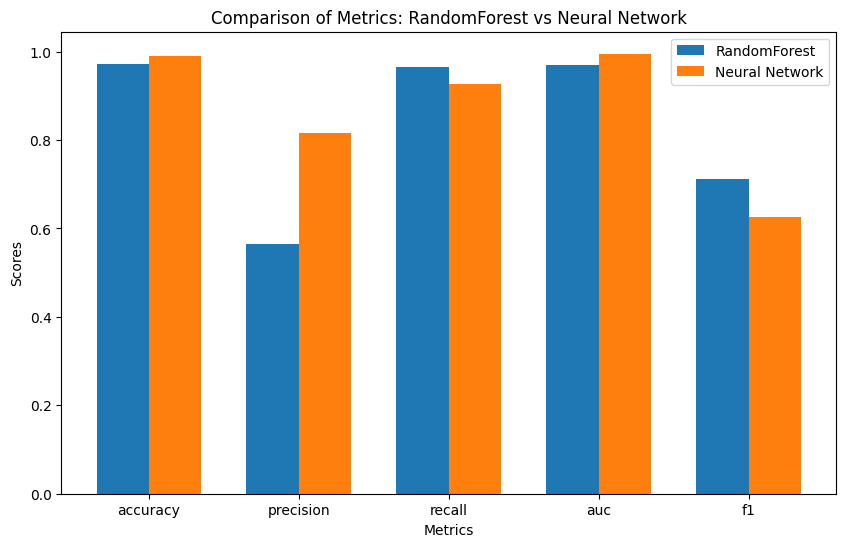

In [39]:
rf_scores = list(rf_scores_dict.values())
nn_scores = list(best_nn_scores.values())[1:]  # Omit the loss
metrics = METRIC_NAMES[1:]  # Omit the loss

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars on the x-axis
rf_positions = range(len(metrics))
nn_positions = [pos + bar_width for pos in rf_positions]

# Create the bar plots
rf_bars = ax.bar(rf_positions, rf_scores, bar_width, label="RandomForest")
val_bars = ax.bar(nn_positions, nn_scores, bar_width, label="Neural Network")

# Add labels and title
ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Comparison of Metrics: RandomForest vs Neural Network")

# Set the x-axis tick labels
ax.set_xticks([pos + bar_width / 2 for pos in rf_positions])
ax.set_xticklabels(metrics)

# Add legend
ax.legend()

# Show the plot
plt.show()

700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


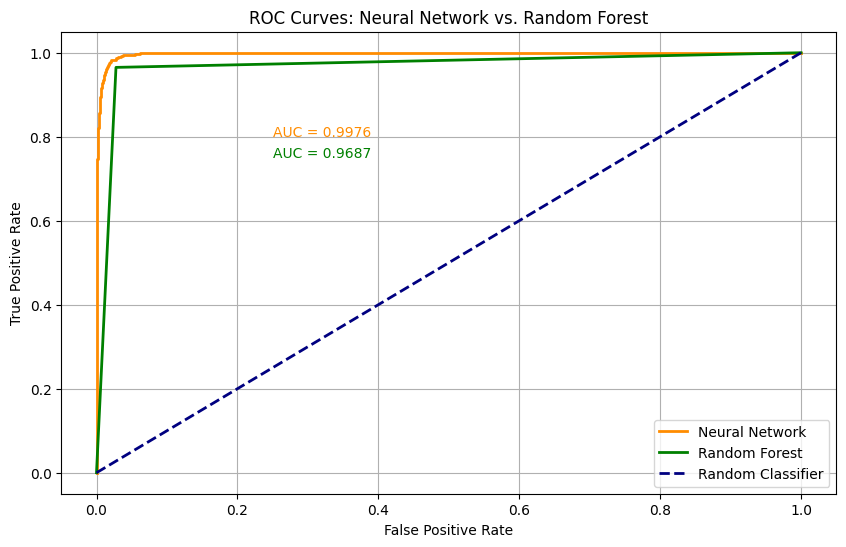

In [41]:
plt.figure(figsize=(10, 6))

# Plot the ROC curve for the oversampling model
y_pred_nn = best_nn_model.predict(X_val)

fpr, tpr, thresholds = roc_curve(y_val, y_pred_nn)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color="darkorange", lw=2, label="Neural Network")
plt.text(0.25, 0.8, f"AUC = {roc_auc:.4f}", color="darkorange")

# Plot the ROC curve for the class weight model
y_pred_rf = rf.predict(X_val)

fpr, tpr, thresholds = roc_curve(y_val, y_pred_rf)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color="green", lw=2, label="Random Forest")
plt.text(0.25, 0.75, f"AUC = {roc_auc:.4f}", color="green")

# Plot the random classifier line
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Classifier")


# Add plot details
plt.title("ROC Curves: Neural Network vs. Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()